In [1]:
import numpy as np
import pickle
import joblib
import pandas as pd
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.run_functions_eagerly(False)  # Habilita la ejecución ansiosa

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Input, TimeDistributed, BatchNormalization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import os
from keras.models import load_model
from keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping

import json
import io
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from comet_ml import Experiment
import optuna

c:\Users\Ing. Biologica\Documents\GitHub\SABI_2025_Molina\entorno_sabi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# establecer semilla, para que shuffle sea igual
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Definición de rutas, variables y funciones

In [3]:

ruta_datos = "../data/"     # defino el directorio de los datos
os.chdir(ruta_datos) # me situo en el directorio

sujeto_part = 5  # sujeto elegido para usar sus datos 
cant_rep =  6 # cantidad de repeticiones por gesto
num_classes = 10  # cantidad de clases a clasificar
BATCH_SIZE = 16
cant_LSTM = 48
lr = 0.00008

# TODO podria sacar estos valores mirando algún dataset
largo_secuencia = 650
cant_canales = 12

nombre_ds = "dataset_x_rep_DB3_650_stride5_sub" + str(sujeto_part) + "_weighted_fold_rep_{rep}"
# nombre_ds = "dataset_x_rep_DB3_650_stride5_sub_norm_" + str(sujeto_part) + "_weighted_fold_rep_{rep}"

In [4]:
# Función para convertir etiquetas a formato one-hot
def one_hot_encode(data, label, weight):
    label = tf.one_hot(label, depth=num_classes, dtype=tf.int8)
    return data, label, weight

In [5]:
archivos = os.listdir()
print(archivos)

['dataset_x_rep_DB3_650_stride5_sub0_weighted_fold_rep_0', 'dataset_x_rep_DB3_650_stride5_sub0_weighted_fold_rep_1', 'dataset_x_rep_DB3_650_stride5_sub0_weighted_fold_rep_2', 'dataset_x_rep_DB3_650_stride5_sub0_weighted_fold_rep_3', 'dataset_x_rep_DB3_650_stride5_sub0_weighted_fold_rep_4', 'dataset_x_rep_DB3_650_stride5_sub0_weighted_fold_rep_5', 'dataset_x_rep_DB3_650_stride5_sub10_weighted_fold_rep_0', 'dataset_x_rep_DB3_650_stride5_sub10_weighted_fold_rep_1', 'dataset_x_rep_DB3_650_stride5_sub10_weighted_fold_rep_2', 'dataset_x_rep_DB3_650_stride5_sub10_weighted_fold_rep_3', 'dataset_x_rep_DB3_650_stride5_sub10_weighted_fold_rep_4', 'dataset_x_rep_DB3_650_stride5_sub10_weighted_fold_rep_5', 'dataset_x_rep_DB3_650_stride5_sub1_weighted_fold_rep_0', 'dataset_x_rep_DB3_650_stride5_sub1_weighted_fold_rep_1', 'dataset_x_rep_DB3_650_stride5_sub1_weighted_fold_rep_2', 'dataset_x_rep_DB3_650_stride5_sub1_weighted_fold_rep_3', 'dataset_x_rep_DB3_650_stride5_sub1_weighted_fold_rep_4', 'datase

# Accedo a datasets y armo conjuntos de datos

In [6]:
ds_reps = []
for j in range(cant_rep):
  nombre_ds_j = nombre_ds.format(rep=j)
  ds_reps.append(tf.data.Dataset.load(nombre_ds_j))

Uso el fold 1 para test, y el 4 para validación. Es decir, todas las repeticiones 1 para test, y todas las repeticiones 4 para validación.

In [7]:
# Armo los 6 folds
folds_rep = [[], [], [], [], [], []]

# TODO mejorar. por ahora lo hago hardcodeado para cada fold

# construyo conjunto de entrenamiento
ds_train_base = ds_reps[0]
ds_train_base = ds_train_base.concatenate(ds_reps[2])
ds_train_base = ds_train_base.concatenate(ds_reps[3])
ds_train_base = ds_train_base.concatenate(ds_reps[5])

# construyo conjuntos de validación y test
ds_val_base = ds_reps[4]
ds_test_base = ds_reps[1]

# Preparación de datos

In [8]:
# observo la forma del primer elemento del conjunto de test
for x, y, z in ds_test_base.take(1):
  input_shape = x.shape
  label_shape = y.shape
  label = y
print('Input shape:', input_shape)
print('Label shape:', label_shape)
print('Label', label)

Input shape: (650, 12)
Label shape: ()
Label tf.Tensor(0, shape=(), dtype=int32)


In [9]:
# funciones de acondicionamiento de los datos
def preparar_ds(ds):
  ds = ds.map(one_hot_encode) # paso las clases a una codificacion one hot
  ds = ds.shuffle(buffer_size=ds.cardinality()) # hago un shuffle de los datos
  ds = ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE) # armo batches y cargo en memoria la cantidad de datos optima, listos para ser utilizados
  return ds

ds_train = preparar_ds(ds_train_base)
ds_val = preparar_ds(ds_val_base)
ds_test = preparar_ds(ds_test_base)

Creo el directorio para guardar el experimento

In [10]:
# elijo el directorio donde quiero guardar los resultados del experimento actual
# nombre_exp = "est4_norm_sin_opt_sujeto_" + str(sujeto_part)
nombre_exp = "est4_sin_opt_sujeto_" + str(sujeto_part)
ruta_experimento = "../clasificacion_sujetos_amputacion/experimentos/" + nombre_exp
os.makedirs(ruta_experimento, exist_ok=True) # me fijo si existe, si no, lo creo
# os.chdir(ruta_experimento) # me situo en el directorio

# Diseño e implementación de RNN

## Defición de la arquitectura


In [11]:
input_shape = (650, 12)
# Definir el modelo con return_sequences=True
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(cant_LSTM, input_shape=input_shape, return_sequences=True),  # Devuelve la secuencia completa
    tf.keras.layers.GlobalAveragePooling1D(),  # Promedia las salidas de la secuencia
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Capa de salida para la clasificación
])

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'], weighted_metrics=['accuracy'])

# Resumen del modelo
model.summary()

c:\Users\Ing. Biologica\Documents\GitHub\SABI_2025_Molina\entorno_sabi\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 650, 48)        │        11,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 48)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,202 (47.66 KB)

 Trainable params: 12,202 (47.66 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento de la RNN

### Si entreno el modelo por primera vez

In [12]:
class CustomSaver(Callback):
    def __init__(self, model_save_path, history_save_path, initial_epoch=0):
        super(CustomSaver, self).__init__()
        self.model_save_path = model_save_path
        self.history_save_path = history_save_path
        self.epoch_offset = initial_epoch
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        # Guardar el modelo
        model_file = os.path.join(self.model_save_path, f'model_epoch_{self.epoch_offset + epoch + 1}.keras')
        self.model.save(model_file)
        print(f'Modelo guardado en {model_file}')

        # Acumular y guardar la historia de entrenamiento
        self.history.append(logs)
        history_file = os.path.join(self.history_save_path, 'complete_history.json')
        with open(history_file, 'w') as f:
            json.dump(self.history, f)
        print(f'Historia de entrenamiento guardada en {history_file}')

# Crear el callback
saver = CustomSaver(model_save_path=ruta_experimento, history_save_path=ruta_experimento)

# Entrenar el modelo
history = model.fit(ds_train, validation_data=ds_val, epochs=20, callbacks=[saver])

Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.0855 - loss: 2.2987 - weighted_accuracy: 0.0842Modelo guardado en ../clasificacion_sujetos_amputacion/experimentos/est4_sin_opt_sujeto_5\model_epoch_1.keras
Historia de entrenamiento guardada en ../clasificacion_sujetos_amputacion/experimentos/est4_sin_opt_sujeto_5\complete_history.json
210/210 ━━━━━━━━━━━━━━━━━━━━ 53s 236ms/step - accuracy: 0.0856 - loss: 2.2987 - weighted_accuracy: 0.0842 - val_accuracy: 0.1986 - val_loss: 2.2845 - val_weighted_accuracy: 0.1978
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.1850 - loss: 2.2806 - weighted_accuracy: 0.1832Modelo guardado en ../clasificacion_sujetos_amputacion/experimentos/est4_sin_opt_sujeto_5\model_epoch_2.keras
Historia de entrenamiento guardada en ../clasificacion_sujetos_amputacion/experimentos/est4_sin_opt_sujeto_5\complete_history.json
210/210 ━━━━━━━━━━━━━━━━━━━━ 42s 198ms/step - accuracy: 0.1850 - loss: 2.2806 - weighted_accuracy: 0.1832 - 

In [ ]:
# Visualizacion de la evolucion del entrenamiento
pd.DataFrame(history.history).plot(
figsize=(8, 5), grid=True, xlabel="Epoch",  # xlim=[0, 10], ylim=[0, 1],
style=["r--", "r--.", "b-", "b-*"])
# plt.savefig("evolucion_entrenamiento.png")

### Si quiero retomar el entrenamiento

In [39]:
class CustomSaver(Callback):
    def __init__(self, model_save_path, history_save_path, initial_epoch=0):
        super(CustomSaver, self).__init__()
        self.model_save_path = model_save_path
        self.history_save_path = history_save_path
        self.epoch_offset = initial_epoch
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        # Guardar el modelo
        model_file = os.path.join(self.model_save_path, f'model_epoch_{epoch + 1}.keras') # self.epoch_offset +
        self.model.save(model_file)
        print(f'Modelo guardado en {model_file}')

        # Acumular y guardar la historia de entrenamiento
        self.history.append(logs)
        history_file = os.path.join(self.history_save_path, 'complete_history.json')
        with open(history_file, 'w') as f:
            json.dump(self.history, f)
        print(f'Historia de entrenamiento guardada en {history_file}')

# Cargar el modelo guardado en la época 3
model = load_model(os.path.join(ruta_experimento, 'model_epoch_60.keras'))

# Cargar la historia de entrenamiento completa
history_file = os.path.join(ruta_experimento, 'complete_history.json')
if os.path.exists(history_file):
    with open(history_file, 'r') as f:
        complete_history = json.load(f)
else:
    complete_history = []

# Crear el callback personalizado para continuar guardando modelos y la historia
saver = CustomSaver(model_save_path=ruta_experimento, history_save_path=ruta_experimento, initial_epoch=len(complete_history))

# Cargar la historia acumulada en el callback
saver.history = complete_history

# AJUSTAR LA EPOCA EN LA QUE RETOMO EL ENTRENAMIENTO
# Continuar el entrenamiento desde la última época. En initial_epoch pongo el numero de la ultima epoca entrenada
model.fit(ds_train, validation_data=ds_val, epochs=80, initial_epoch=60, callbacks=[saver])

Epoch 61/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8788 - loss: 0.6054 - weighted_accuracy: 0.8806Modelo guardado en ../clasificacion_sujetos_amputacion/experimentos/est4_norm_sin_opt_sujeto_5\model_epoch_61.keras
Historia de entrenamiento guardada en ../clasificacion_sujetos_amputacion/experimentos/est4_norm_sin_opt_sujeto_5\complete_history.json
210/210 ━━━━━━━━━━━━━━━━━━━━ 47s 207ms/step - accuracy: 0.8789 - loss: 0.6053 - weighted_accuracy: 0.8806 - val_accuracy: 0.6330 - val_loss: 1.0621 - val_weighted_accuracy: 0.6306
Epoch 62/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8997 - loss: 0.5632 - weighted_accuracy: 0.9011Modelo guardado en ../clasificacion_sujetos_amputacion/experimentos/est4_norm_sin_opt_sujeto_5\model_epoch_62.keras
Historia de entrenamiento guardada en ../clasificacion_sujetos_amputacion/experimentos/est4_norm_sin_opt_sujeto_5\complete_history.json
210/210 ━━━━━━━━━━━━━━━━━━━━ 43s 204ms/step - accuracy: 0.8997 - loss: 0.5632 - weig

### Si el modelo está entrenado

In [43]:
class CustomSaver(Callback):
    def __init__(self, model_save_path, history_save_path, initial_epoch=0):
        super(CustomSaver, self).__init__()
        self.model_save_path = model_save_path
        self.history_save_path = history_save_path
        self.epoch_offset = initial_epoch
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        # Guardar el modelo
        model_file = os.path.join(self.model_save_path, f'model_epoch_{epoch + 1}.keras') # self.epoch_offset +
        self.model.save(model_file)
        print(f'Modelo guardado en {model_file}')

        # Acumular y guardar la historia de entrenamiento
        self.history.append(logs)
        history_file = os.path.join(self.history_save_path, 'complete_history.json')
        with open(history_file, 'w') as f:
            json.dump(self.history, f)
        print(f'Historia de entrenamiento guardada en {history_file}')

# ELIJO QUE EPOCA QUIERO USAR, PUEDO MIRAR LA GRAFICA Y ELEGIR LA MEJOR
# Cargar el modelo guardado en la época 3
model = load_model(os.path.join(ruta_experimento, 'model_epoch_82.keras'))

# Cargar la historia de entrenamiento completa
history_file = os.path.join(ruta_experimento, 'complete_history.json')
if os.path.exists(history_file):
    with open(history_file, 'r') as f:
        complete_history = json.load(f)
else:
    complete_history = []

# Crear el callback personalizado para continuar guardando modelos y la historia
saver = CustomSaver(model_save_path=ruta_experimento, history_save_path=ruta_experimento, initial_epoch=len(complete_history))

# Cargar la historia acumulada en el callback
saver.history = complete_history

ValueError: File not found: filepath=../clasificacion_sujetos_amputacion/experimentos/est4_norm_sin_opt_sujeto_5\model_epoch_82.keras. Please ensure the file is an accessible `.keras` zip file.

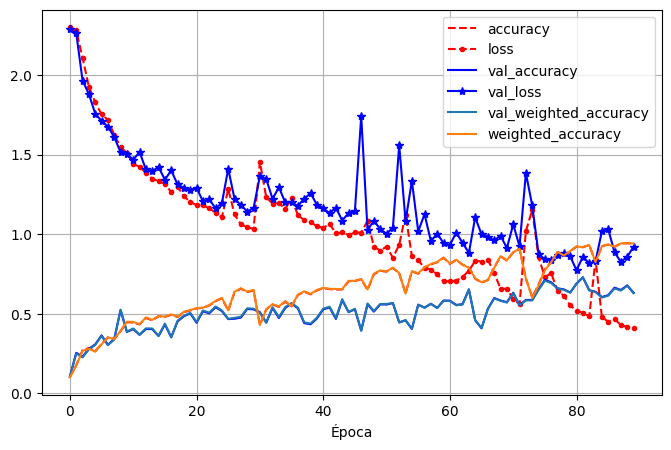

In [41]:
# Visualizacion de la evolucion del entrenamiento
pd.DataFrame(complete_history).plot(
figsize=(8, 5), grid=True, xlabel="Época",  # xlim=[0, 10], ylim=[0, 1],
style=["r--", "r--.", "b-", "b-*"])
plt.savefig("evolucion_entrenamiento.pdf")

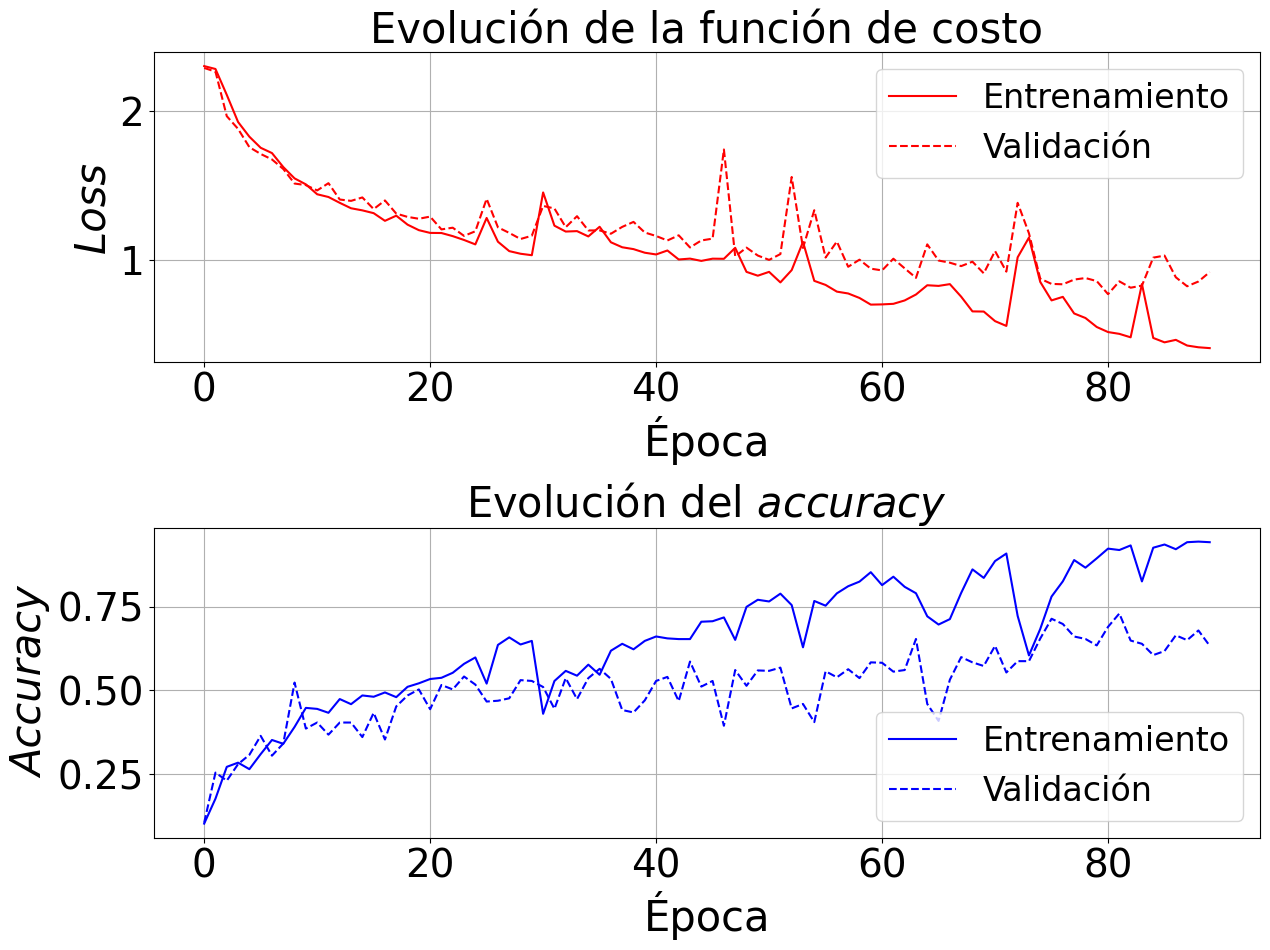

In [42]:
df = pd.DataFrame(complete_history)

# Crear figura con dos subgráficos (uno arriba del otro)
fig, axes = plt.subplots(2, 1, figsize=(12.8, 9.6))

# Gráfico de pérdida (loss y val_loss)
df[['loss', 'val_loss']].plot(ax=axes[0], grid=True, style=["r-", "r--"])
axes[0].set_title("Evolución de la función de costo", fontsize=30)
axes[0].set_xlabel("Época", fontsize=30)
axes[0].set_ylabel("Loss", fontsize=30, style='italic')
axes[0].legend(["Entrenamiento", "Validación"], fontsize=24)
axes[0].tick_params(axis='both', labelsize=28)

# Gráfico de precisión (accuracy y val_accuracy)
df[['accuracy', 'val_accuracy']].plot(ax=axes[1], grid=True, style=["b-", "b--"])
axes[1].set_title("Evolución del $accuracy$", fontsize=30)
axes[1].set_xlabel("Época", fontsize=30)
axes[1].set_ylabel("Accuracy", fontsize=30, style='italic')
axes[1].legend(["Entrenamiento", "Validación"], fontsize=24)
axes[1].tick_params(axis='both', labelsize=28)

# Ajustar diseño y guardar figura
plt.tight_layout()
plt.savefig("evolucion_entrenamiento.pdf")

# Adaptación para hacer los evaluate- obtener resultados
Para ejecutar esta parte tengo que tener el modelo entrenado y los dataset base cargados en memoria. Si el modelo ya está entrenado tengo que ejecutar la celda correspondiente.

## Cálculo de predicciones

In [31]:
# armo batches en los conjuntos para poder realizar predicciones
ds_train_batch = ds_train_base.batch(16)
ds_val_batch = ds_val_base.batch(16)
ds_test_batch = ds_test_base.batch(16)

In [32]:
# # Obtener las predicciones en 1hot
y_pred_train_1hot = model.predict(ds_train_batch)
y_pred_val_1hot = model.predict(ds_val_batch)
y_pred_test_1hot = model.predict(ds_test_batch)

191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step


Se puede ver que las predicciones no quedaron organizadas en batches, pero sí devuelven un vector codificado en one hot.

In [ ]:
def onehot2numerical(y_pred):
  # Convertir de one-hot a clases numéricas las predicciones
  y_clases = tf.argmax(y_pred, axis=-1)
  # Convertir a numpy si es necesario
  y_clases_numpy = y_clases.numpy()
  return y_clases_numpy

y_pred_train = onehot2numerical(y_pred_train_1hot)
y_pred_val = onehot2numerical(y_pred_val_1hot)
y_pred_test = onehot2numerical(y_pred_test_1hot)

## Extracción de etiquetas reales

In [ ]:
def extraer_etiquetas_ds(ds):
  y_train_true_list = []
  # for x, y, z in ds: # dataset_with_classes ds_train
  for x, y, z in ds:
    # print(y.shape)
    y_train_true_list.append(y.numpy())
  return y_train_true_list

y_true_train_list = extraer_etiquetas_ds(ds_train_base)
y_true_val_list = extraer_etiquetas_ds(ds_val_base)
y_true_test_list = extraer_etiquetas_ds(ds_test_base)

In [ ]:
y_true_train_array = np.array(y_true_train_list)
y_true_val_array = np.array(y_true_val_list)
y_true_test_array = np.array(y_true_test_list)

# print(y_true_train_array.shape)

In [ ]:
# Visualizacion de ejemplo
y_true_train_list[2]

0

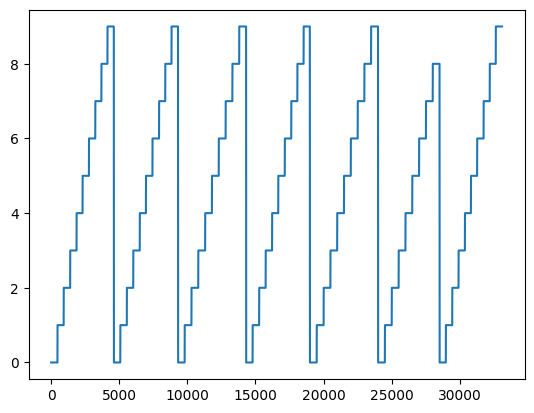

In [ ]:
plt.figure()
plt.plot(y_true_train_array)

### Chequeo si hay nan

In [ ]:
# Chequeo si hay alguna etiqueta nan
nan_indices = np.isnan(y_true_train_array)
np.where(nan_indices==True)[0]

array([], dtype=int64)

In [ ]:
# En los datos crudos
# extraigo datos
def extraer_datos_ds(ds):
  x_train_true_list = []
  for x, y, z in ds: # dataset_with_classes ds_train
    # print(y.shape)
    x_train_true_list.append(x.numpy())
    # print(x.shape)
  return x_train_true_list

x_true_train_list = extraer_datos_ds(ds_train_base)
# y_true_val_list = extraer_etiquetas_ds(ds_val_base)
# y_true_test_list = extraer_etiquetas_ds(ds_test_base)

In [ ]:
x_true_train_array = np.array(x_true_train_list)

# Matrices de confusión

In [ ]:
os.chdir(ruta_experimento) # me situo en el directorio

Accuracy en entrenamiento: 0.9605


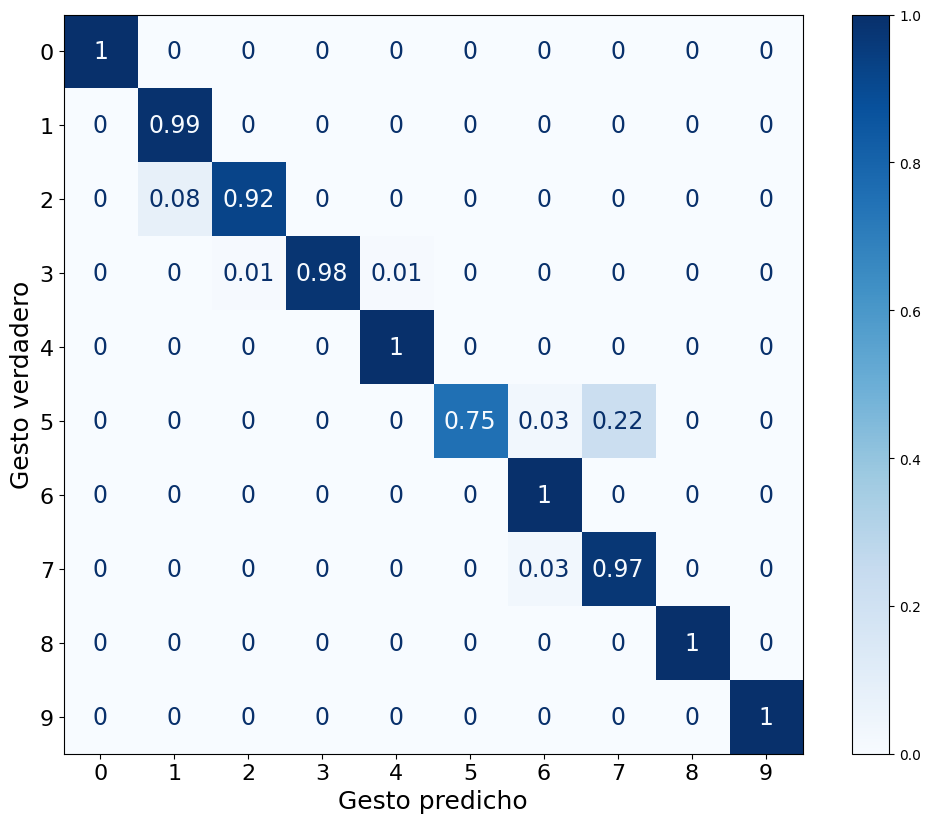

Accuracy en validación: 0.8833


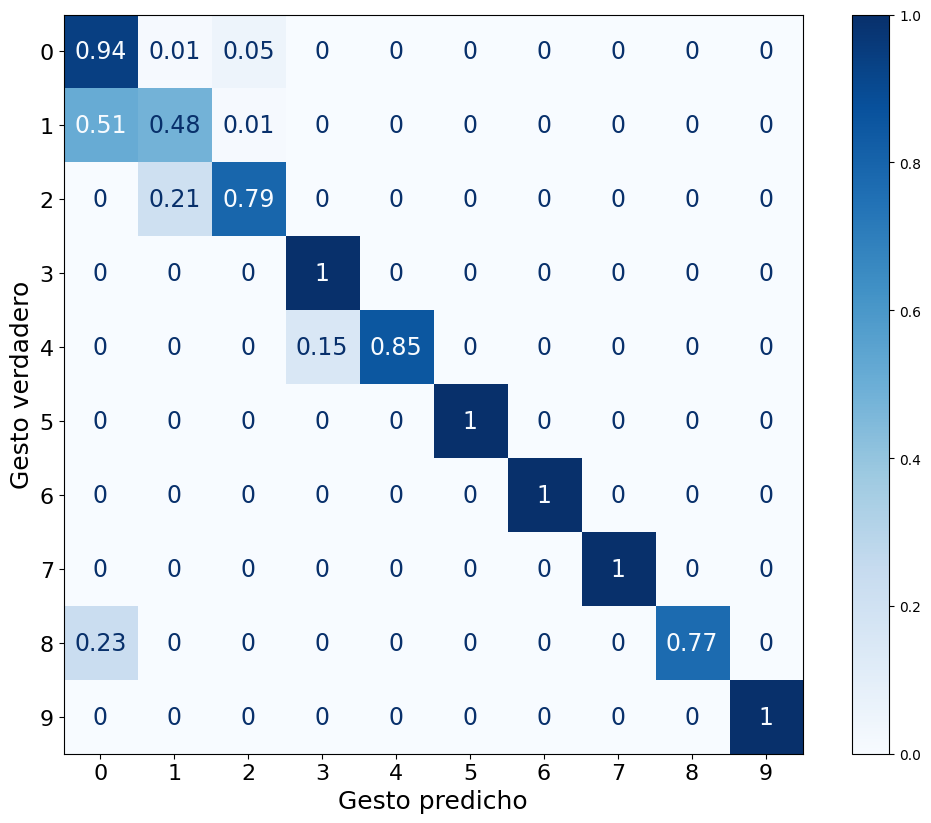

Accuracy en test: 0.8783


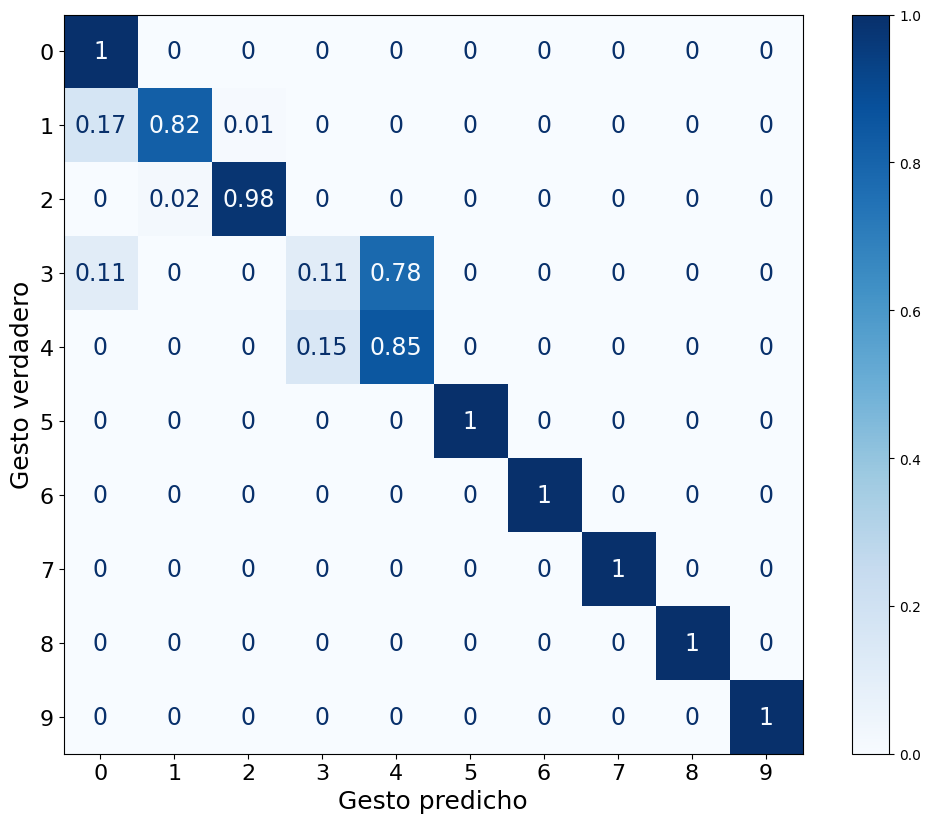

In [ ]:
def calcular_accuracy(y_true, y_pred, nombre_conjunto):
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy en {nombre_conjunto}: {accuracy:.4f}')
    return accuracy
def generar_matriz_confusion_normalizada(y_true, y_pred, title, ruta_guardar, decimales=2):
    # Generar la matriz de confusión normalizada (por clase)
    conf_matrix = confusion_matrix(y_true, y_pred, normalize='true', labels=classes)

    # Redondear la matriz a la cantidad de decimales especificados
    conf_matrix = np.round(conf_matrix, decimals=decimales)

    # Crear la figura con un tamaño personalizado
    fig, ax = plt.subplots(figsize=(12.8, 9.6))  # Ajusta el tamaño según tus necesidades

    # Crear el display
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=plt.cm.Blues, ax=ax)  # Pasar 'ax' para usar el tamaño personalizado

    # Configurar los nombres de los ejes
    disp.ax_.set_xlabel('Gesto predicho', fontsize=18)
    disp.ax_.set_ylabel('Gesto verdadero', fontsize=18)

    # Aumentar el tamaño de las etiquetas de los ejes (tick labels)
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Cambiar el tamaño de los números dentro de la matriz
    for text in disp.ax_.texts:
        text.set_fontsize(17)  # Cambia el tamaño de los números dentro de la matriz

    # Guardar la figura
    plt.savefig(ruta_guardar, dpi=600, bbox_inches='tight')  # bbox_inches evita recortes indeseados
    plt.show()

# # Para el conjunto de entrenamiento
accuracy_train = calcular_accuracy(y_true_train_array, y_pred_train, 'entrenamiento')
generar_matriz_confusion_normalizada(y_true_train_array, y_pred_train, 'Confusion Matrix (Normalized) - Training Data', 'train_normalized.png')

# Para el conjunto de validación
accuracy_val = calcular_accuracy(y_true_val_array, y_pred_val, 'validación')
generar_matriz_confusion_normalizada(y_true_val_array, y_pred_val, 'Confusion Matrix (Normalized) - Validation Data', 'val_normalized.png')

# Para el conjunto de test
accuracy_test = calcular_accuracy(y_true_test_array, y_pred_test, 'test')
generar_matriz_confusion_normalizada(y_true_test_array, y_pred_test, 'Confusion Matrix (Normalized) - Test Data','test_normalized.png')


Accuracy en entrenamiento: 0.9605


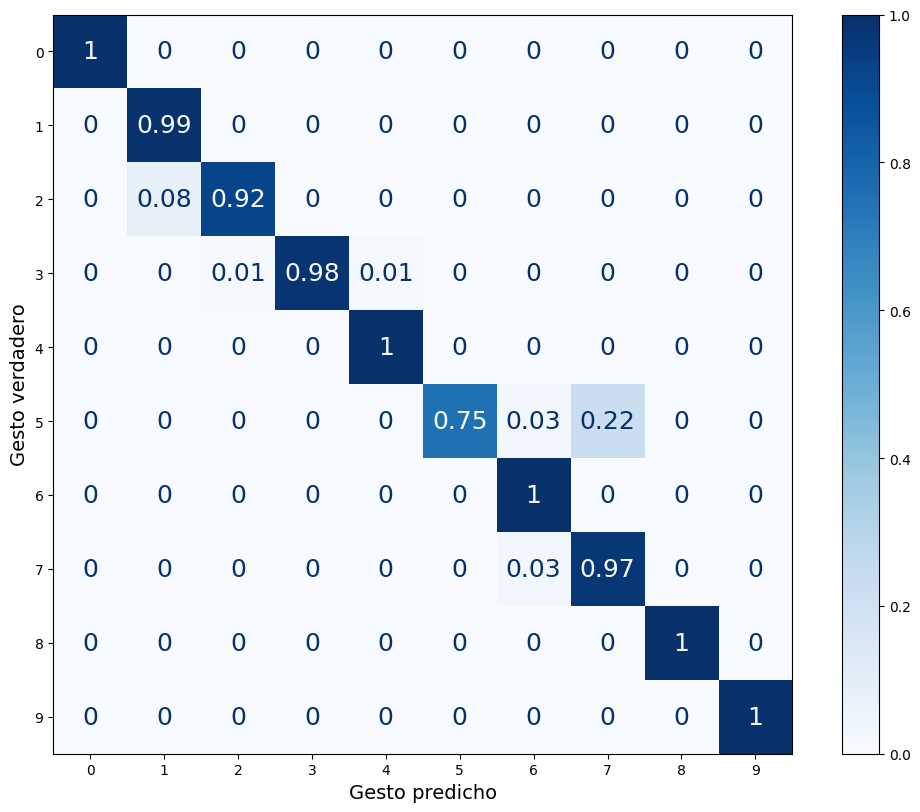

Accuracy en validación: 0.8833


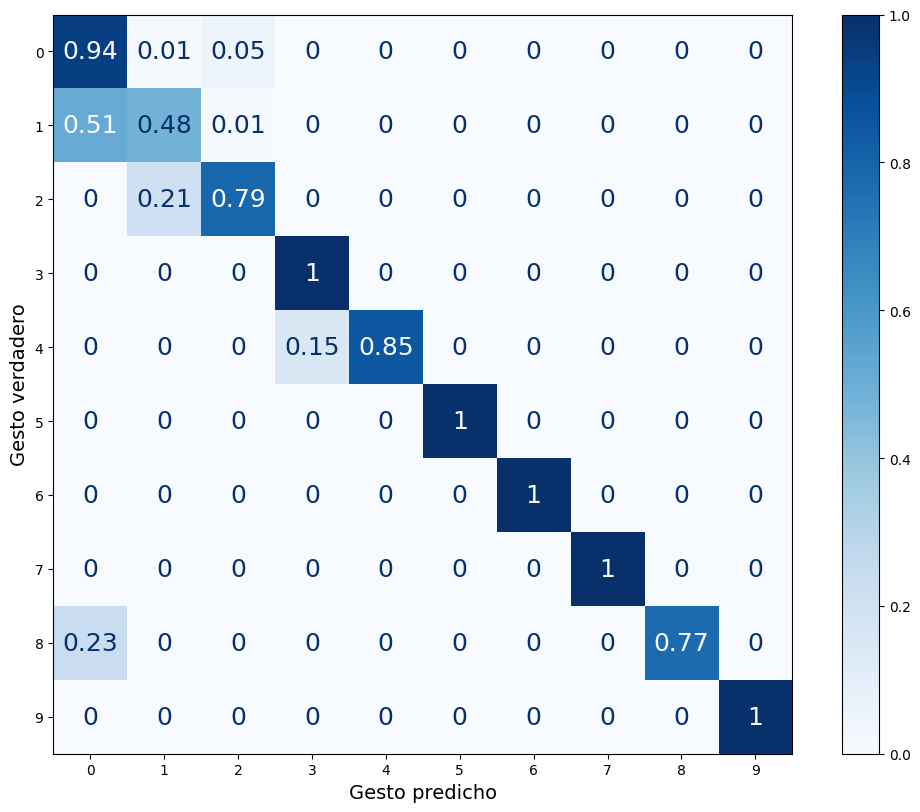

Accuracy en test: 0.8783


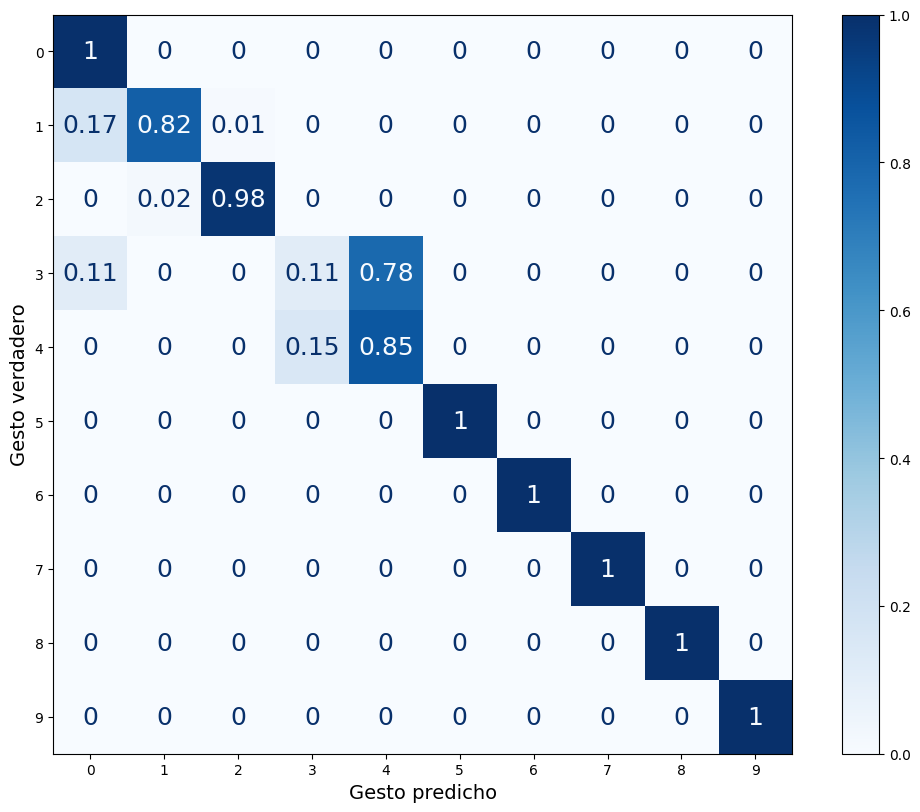

In [ ]:
# Función para generar y guardar la matriz de confusión con proporciones redondeadas
def generar_matriz_confusion_normalizada(y_true, y_pred, title, ruta_guardar, decimales=2):
    # Generar la matriz de confusión normalizada (por clase)
    conf_matrix = confusion_matrix(y_true, y_pred, normalize='true', labels=classes)

    # Redondear la matriz a la cantidad de decimales especificados
    conf_matrix = np.round(conf_matrix, decimals=decimales)

    # Crear el display
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # plt.figure(figsize=(12.8, 9.6))
    # Graficar
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_xlabel('Gesto predicho', fontsize=14)
    disp.ax_.set_ylabel('Gesto verdadero', fontsize=14)
    disp.figure_.set_size_inches(12.8, 9.6)
    # plt.title(title)
    for text in disp.ax_.texts:
      text.set_fontsize(18)  # Cambia el tamaño aquí, por ejemplo, 14
    # Guardar la figura
    plt.savefig(ruta_guardar, dpi = 600)
    plt.show()

# Función para calcular y mostrar el accuracy
def calcular_accuracy(y_true, y_pred, nombre_conjunto):
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy en {nombre_conjunto}: {accuracy:.4f}')
    return accuracy

# # Para el conjunto de entrenamiento
accuracy_train = calcular_accuracy(y_true_train_array, y_pred_train, 'entrenamiento')
generar_matriz_confusion_normalizada(y_true_train_array, y_pred_train, 'Confusion Matrix (Normalized) - Training Data', 'train_normalized.png')

# Para el conjunto de validación
accuracy_val = calcular_accuracy(y_true_val_array, y_pred_val, 'validación')
generar_matriz_confusion_normalizada(y_true_val_array, y_pred_val, 'Confusion Matrix (Normalized) - Validation Data', 'val_normalized.png')

# Para el conjunto de test
accuracy_test = calcular_accuracy(y_true_test_array, y_pred_test, 'test')
generar_matriz_confusion_normalizada(y_true_test_array, y_pred_test, 'Confusion Matrix (Normalized) - Test Data','test_normalized.png')


# Guardar experimento en Comet

In [ ]:
joblib.dump(conf_matrix_train, "cm_train_"+nombre_exp+".pkl")
joblib.dump(conf_matrix_val, "cm_val_"+nombre_exp+".pkl")
joblib.dump(conf_matrix_test, "cm_test_"+nombre_exp+".pkl")

['cm_test_GI_estrategia4_sujeto5_opt.pkl']

In [ ]:
# Guardar resumen en una cadena de texto para guardarlo en Comet
stream = io.StringIO()
model.summary(print_fn=lambda x: stream.write(x + '\n'))
summary_str = stream.getvalue()
stream.close()

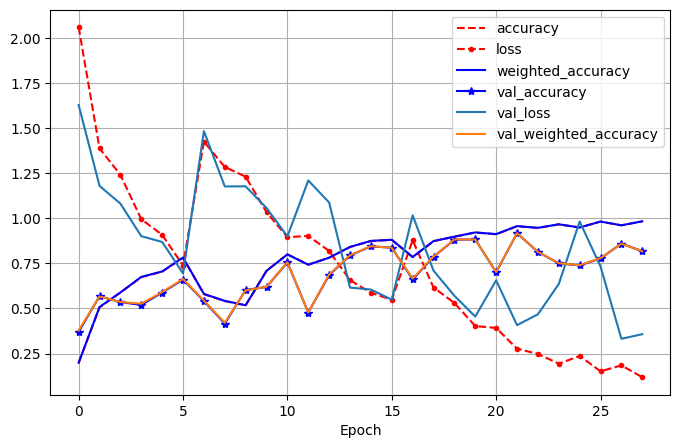

In [ ]:
nombre = nombre_exp
joblib.dump(model, nombre + '.pkl')
pd.DataFrame(complete_history).plot(
figsize=(8, 5), grid=True, xlabel="Epoch",  # xlim=[0, 10], ylim=[0, 1],
style=["r--", "r--.", "b-", "b-*"])
plt.savefig("evolucion_entrenamiento.png")

In [ ]:
# API_KEY = 'ehXeElNypcj7Knar5zTmyjwSO'

exp = Experiment(api_key=API_KEY,
              project_name='tesis-experimentos', # Nombre del proyecto donde se registran los experimentos
              auto_param_logging=False)
exp.set_name(nombre) # Nombre de este experimento
exp.add_tags(['ronda_GI', 'estrategia5', '10_gestos','seq_vector', 'x_sujeto']) # Tags,'particion_1'

exp.log_metric("test_accuracy_rank", accuracy_test)
exp.log_metric("val_accuracy_rank", accuracy_val)
exp.log_metric("train_accuracy_rank", accuracy_train)

exp.log_parameter("batch_size", BATCH_SIZE)
exp.log_parameter("stride", 5)
exp.log_parameter("largo_secuencia", 650)
exp.log_parameter("stop_epoch", 20)
exp.log_parameter("sample_weight", 0)
exp.log_parameter("porcentaje_label", 100)
exp.log_parameter("cantidad_gestos", 10)
exp.log_parameter("particion_datos", 1)
exp.log_parameter("lr", format(lr, ".8g"))
exp.log_parameter("sujeto", 5)


# # solo si es por sujeto
# exp.log_parameter("sujetos train", ind_train)
# exp.log_parameter("sujetos validacion", ind_val)
# exp.log_parameter("sujetos test", ind_test)

# Guardar la imagen en Comet
exp.log_image("evolucion_entrenamiento.png")

exp.log_image('train.png')
exp.log_image('val.png')
exp.log_image('test.png')

exp.log_image('train_normalized.png')
exp.log_image('val_normalized.png')
exp.log_image('test_normalized.png')

exp.log_asset("cm_train_"+nombre_exp+".pkl")
exp.log_asset("cm_val_"+nombre_exp+".pkl")
exp.log_asset("cm_test_"+nombre_exp+".pkl")

exp.log_text("Estrategia 4 con optimización, por repeticion..\n")   # Comentario del experimento
exp.log_text("Model Summary:\n" + summary_str)
exp.log_model(name=nombre, file_or_folder=nombre + '.pkl')
exp.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, keras, tensorflow.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/92872484d95445bda2594816d1955c19

COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 